# Loading the video

Mount Google drive through using drive.mount('/content/drive') Ceate a shortcut to the class Google Drive home directory to the location where the data is: Open the class Google Doc Folder https://drive.google.com/drive/folders/17dFdrIbTp8RjivAuOiLNyb8pTqZ8QqgL ("SCIP_IMAGE_PYTHON_2022"), Right click on "SCIP_DATA",click "Add shortcut to drive".

Run the code below to mount the class code data. You should be able to find image and video files in the folder (on the left) under drive/MyDrive/SCIP_DATA.

In [ ]:
#import glob
from google.colab import drive
import matplotlib.pyplot as plt
from IPython import display
from time import sleep
import cv2
#%matplotlib inline 
from google.colab.patches import cv2_imshow

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read video frame by frame

Let's play the first view video frames using the CV2 method cv2.VideoCapture(vid). The original video is 1920x1080 (1080p HD) resolution. To speed up the display, reduce the size of the frame to 480x270 (1/4 the size).

In [ ]:
vid='/content/drive/MyDrive/SCIP_DATA/Video/planktonWhite_1920_1080.mp4'
cap = cv2.VideoCapture(vid)
frameCount=0
framesToDisplay=30
xRez=480; yRez=270; # reduce image so display is faster
print('Cap opened?',cap.isOpened())
while(cap.isOpened() and frameCount<framesToDisplay):
    # get image
    ret, frameIM = cap.read()
    frameIM = cv2.resize(frameIM, (xRez, yRez))
    if not ret: # check to make sure there was a frame to read
        print('Can not find video or we are all done')
        break
    cv2_imshow(frameIM)
    print('frame=',frameCount)
    sleep(.3)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    frameCount+=1
cap.release()


<Figure size 432x288 with 0 Axes>

#Problem 1. Reading a specified frame from the video
Video usually is recorded at 30 frames per second. Instead of viewing every frame, show every 30th frame, so you will see one frame per second. To do this use the command...
>cap.set(cv2.CAP_PROP_POS_FRAMES, frameNumber)

... right before you read a frame (ret, frameIM = cap.read()). frameNumber is the frame you want to use (frameNumber=0 is the first frame of the video). 


#Convert Image to Grayscale and Crop Image

We will do our detection on a binary image, so first step is to convert the color image of the frame to a grayscale image.

You may notice there is a black boarder around the frame, caused by the editing program used to make the video. While this does not affect the appearance, it will cause our object detector to see the whole frame as an object, since we treat dark pixels as objects. Either we must make the boarder white, or crop the image to get rid of the black boarder. Cropping is easier, so after we convert the image to grayscale, we'll crop the image to get rid of the black border.

In [ ]:
frameCount=0
CROP_SIZE=4 # number of pixels to remove on each side of image
cap = cv2.VideoCapture(vid)
while(cap.isOpened() and frameCount<framesToDisplay):
    # get image
    ret, frameIM = cap.read()

    # resize image so it fits in the small display window
    frameIM = cv2.resize(frameIM, (xRez, yRez))
    
    # convert to gray image
    grayIM = cv2.cvtColor(frameIM, cv2.COLOR_BGR2GRAY)    # convert color to grayscale image
    
    # crop image to get rid of black boarder
    grayCropIM=grayIM[CROP_SIZE:yRez-CROP_SIZE,CROP_SIZE:xRez-CROP_SIZE]
    
    # display image
    cv2_imshow(grayCropIM)
    sleep(.3)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    frameCount+=1
cap.release()

<Figure size 432x288 with 0 Axes>

#Problem 2: Cropping a specific window from the video frame
Use the cropping function to select a portion of the whole video frame with a large plankton (Blepherisma). Use the command...
>grayCropIM=grayIM[y0:y0+h, x0:x0+w]

... and adjust x0,w,y0,h until you've cropped the large plankton.

# Binary quantize image

Each frame is a color image. The first steps in detecting objects is to convert each image into a grayscale image, where each pixel has a value between 0 (black) and 255 (white). If a pixel is below the threshold, it will be assigned the value 0 (black). If a pixel is above the threshold, it will be assigned a value of 255 (white). However, notice our objects are darker than the background. In order for the pixels in our objects to be detected, they must assigned a value of 255 (white). We will use the flag cv2.THRESH_BINARY_INV to invert the assignment, so our objects will appear white (255).  



In [ ]:
thresh=80 # used to determine if a pixel is assigned 0 or 255
frameCount=0
CROP_SIZE=4 # number of pixels to remove on each side of image
cap = cv2.VideoCapture(vid)
while(cap.isOpened() and frameCount<framesToDisplay):
    # get image
    ret, frameIM = cap.read()
    frameIM = cv2.resize(frameIM, (xRez, yRez))
    grayIM = cv2.cvtColor(frameIM, cv2.COLOR_BGR2GRAY)    # convert color to grayscale image
    grayIM=grayIM[CROP_SIZE:yRez-CROP_SIZE,CROP_SIZE:xRez-CROP_SIZE]
    ret,binaryIM = cv2.threshold(grayIM,thresh,255,cv2.THRESH_BINARY_INV) # invert threshold output so dark objects show as white
    cv2_imshow(binaryIM)
    sleep(.3)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    frameCount+=1
cap.release()

<Figure size 432x288 with 0 Axes>

#Problem 3: Determine best threshold value
How did I come up with a threshold of 80 (thresh=80)? One way to determine a good threshold value is to program a loop that varies the threshold from low to high value, and visually inspect the output to determine the best threshold. Hint, create a loop that goes from 1 to 200 in steps of two, to speed things up...
>for thresh in range(1,200,2):

# Detect objects in binary quantized image

Now we have a binary image where the objects are white (255) and the background is black (0). This is just what the cv2.findCountours method requires to detect objects. Once detected, we will put a rectangle around each object ton indicte it has been detected.

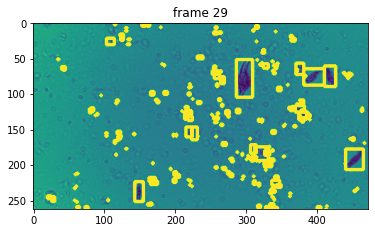

In [ ]:
thresh=80 # used to determine if a pixel is assigned 0 or 255
frameCount=0
CROP_SIZE=4 # number of pixels to remove on each side of image
thick=3   # thickness of rectangle lines around detected objects
cap = cv2.VideoCapture(vid)
while(cap.isOpened() and frameCount<framesToDisplay):
    # get image
    ret, frameIM = cap.read()
    if not ret: # check to make sure there was a frame to read
      print('Can not find video or we are all done')
      break
    frameIM = cv2.resize(frameIM, (xRez, yRez))
    grayIM = cv2.cvtColor(frameIM, cv2.COLOR_BGR2GRAY)    # convert color to grayscale image
    grayIM=grayIM[CROP_SIZE:yRez-CROP_SIZE,CROP_SIZE:xRez-CROP_SIZE]
    ret,binaryIM = cv2.threshold(grayIM,thresh,255,cv2.THRESH_BINARY_INV) # threshold image to make pixels 0 or 255
    
    # detect objects in binaryIM
    contourList, hierarchy = cv2.findContours(binaryIM, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # all countour points, uses more memory
    objectCount=0 # counts number of objects detected
    for objContour in contourList:
        PO = cv2.boundingRect(objContour)
        x0=PO[0]; y0=PO[1]; w=PO[2]; h=PO[3]
        cv2.rectangle(grayIM, (x0,y0), (x0+w,y0+h),255, thick) # place rectangle around each object, BGR
        objectCount+=1
    plt.imshow(grayIM)
    plt.title('frame ' + str(frameCount))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    frameCount+=1
cap.release()

#Problem 4 Detecting the largest object in the frame
To detect the largest object in each frame, make a list of the area of each object, find the greatest area, then use the contour points of the object with the largest area to mark it's location.


> areaList=[] # we will fill this with the area of all the objects
> maxArea=max(areaList)             # find the max area in the list
> maxIndex=areaList.index(maxArea)  # find location of max area in list





# Limiting object detection by area

Notice there are lots of objects detected, but we only want the plankton, so we will use size (area) to select the objects we want. To confirm we are detecting just the images we want, we will place a rectangle around them.

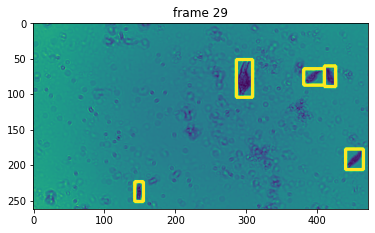

In [ ]:
thresh=80 # used to determine if a pixel is assigned 0 or 255
frameCount=0
minArea=100; maxArea=10000; # in pixels
CROP_SIZE=4 # number of pixels to remove on each side of image
thick=3   # thickness of rectangle lines around detected objects
cap = cv2.VideoCapture(vid)
while(cap.isOpened() and frameCount<framesToDisplay):
    # get image
    ret, frameIM = cap.read()
    if not ret: # check to make sure there was a frame to read
      print('Can not find video or we are all done')
      break
    frameIM = cv2.resize(frameIM, (xRez, yRez))
    grayIM = cv2.cvtColor(frameIM, cv2.COLOR_BGR2GRAY)    # convert color to grayscale image
    grayIM=grayIM[CROP_SIZE:yRez-CROP_SIZE,CROP_SIZE:xRez-CROP_SIZE]
    ret,binaryIM = cv2.threshold(grayIM,thresh,255,cv2.THRESH_BINARY_INV) # threshold image to make pixels 0 or 255
    
    # detect objects in binaryIM
    contourList, hierarchy = cv2.findContours(binaryIM, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # all countour points, uses more memory
    objectCount=0 # counts number of objects detected
    for objContour in contourList:
      area = cv2.contourArea(objContour)
      if area>minArea and area<maxArea:
        #print('frame',frameCount,'object',objectCount,'area',area)
        PO = cv2.boundingRect(objContour)
        x0=PO[0]; y0=PO[1]; w=PO[2]; h=PO[3]
        cv2.rectangle(grayIM, (x0,y0), (x0+w,y0+h),255, thick) # place rectangle around each object, BGR
        objectCount+=1
    plt.imshow(grayIM)
    plt.title('frame ' + str(frameCount))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    frameCount+=1
cap.release()

#Problem 5 Color code objects by size
Put a yellow rectangle around objects that are too small, a red rectangle around objects that are too big, and a green rectangle around objects that are neither too small or large. Since we want to represent color, use the original color frame (frameIM) to draw the colored rectangles on. For example, to place YELLOW rectangle around each small object (color format=RGB, yellow=red+green)...

>cv2.rectangle(frameIM, (x0,y0), (x0+w,y0+h),(255,255,0), thick) 
